In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, RNN,GRU,Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras import regularizers



In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
# Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
# Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
additional_metrics = ['accuracy']
batch_size = 64
loss_function = categorical_crossentropy
number_of_epochs = 25
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

In [4]:
data=pd.read_csv("DogMoveData.csv",memory_map=True)
data=data.dropna()
data

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1,Behavior_2,Behavior_3,PointEvent
0,16,1,0.00,0.041504,0.938965,-0.015137,-0.067871,-0.510254,-0.934570,-17.639161,-22.766115,7.446290,-7.934571,6.347657,13.427735,<undefined>,<undefined>,<undefined>,<undefined>,<undefined>
1,16,1,0.01,0.041992,0.941895,-0.020020,-0.128906,-0.494141,-0.913086,-15.075685,-11.413575,4.821778,-3.906250,4.394532,16.540528,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
2,16,1,0.02,0.040527,0.939453,-0.004395,-0.158691,-0.480469,-0.911133,-12.207032,-0.122070,2.807617,-0.488281,-1.953125,26.794435,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
3,16,1,0.03,0.021484,0.946289,0.007813,-0.122070,-0.486816,-0.880371,-9.460450,7.995606,1.586914,1.159668,-5.676270,38.085940,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
4,16,1,0.04,-0.000977,0.951172,0.033691,-0.053711,-0.500000,-0.807129,-8.361817,14.587403,-1.037598,4.577637,4.089356,41.503909,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10611063,74,2,1928.19,0.018066,0.436523,0.808105,-0.620605,0.326172,-0.647949,23.620607,75.317387,77.148442,-124.511726,107.727057,-122.497566,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611064,74,2,1928.20,-0.021973,0.515625,0.813965,-0.671875,0.241211,-0.660645,34.729006,63.293461,79.956060,-116.455085,97.534186,-123.229988,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611065,74,2,1928.21,-0.041504,0.507324,0.782227,-0.674805,0.244629,-0.627930,39.978030,49.316409,84.655767,-104.858405,95.458990,-124.816902,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611066,74,2,1928.22,-0.032715,0.484375,0.824219,-0.685059,0.211426,-0.578613,38.024905,32.775881,89.538580,-87.463384,101.257330,-128.601082,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>


In [5]:
data = data.drop(data[data['Behavior_1'] == '<undefined>'].index)
data=data.drop(data[data['Behavior_1'] == 'Synchronization'].index)
data=data.drop(data[data['Behavior_1'] == 'Extra_Synchronization'].index)
#view updated DataFrame
data=data.drop(['Behavior_2','Behavior_3','PointEvent'],axis=1)
data

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1
9081,16,1,90.81,-0.272949,0.204102,1.185547,-0.394043,-0.187500,-0.801270,-39.489749,62.500004,35.766604,-11.718751,52.185062,-75.378423,Task walk,Walking
9082,16,1,90.82,-0.296875,-0.004883,1.074219,-0.418457,-0.088867,-0.817383,-42.114260,39.794924,44.250491,-5.493164,55.969242,-67.749028,Task walk,Walking
9083,16,1,90.83,-0.248535,-0.142578,0.994141,-0.440918,-0.052246,-0.799316,-41.564944,12.878419,59.997562,-2.990723,54.016117,-55.236820,Task walk,Walking
9084,16,1,90.84,-0.170898,-0.216797,0.927246,-0.457520,-0.034668,-0.791504,-34.240725,-14.099122,75.866704,4.333496,47.058108,-38.940432,Task walk,Walking
9085,16,1,90.85,-0.084473,-0.226563,0.871094,-0.445313,-0.052734,-0.791504,-23.376466,-31.494143,91.247564,13.427735,33.508303,-23.315431,Task walk,Walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10611063,74,2,1928.19,0.018066,0.436523,0.808105,-0.620605,0.326172,-0.647949,23.620607,75.317387,77.148442,-124.511726,107.727057,-122.497566,Task treat-search,Sniffing
10611064,74,2,1928.20,-0.021973,0.515625,0.813965,-0.671875,0.241211,-0.660645,34.729006,63.293461,79.956060,-116.455085,97.534186,-123.229988,Task treat-search,Sniffing
10611065,74,2,1928.21,-0.041504,0.507324,0.782227,-0.674805,0.244629,-0.627930,39.978030,49.316409,84.655767,-104.858405,95.458990,-124.816902,Task treat-search,Sniffing
10611066,74,2,1928.22,-0.032715,0.484375,0.824219,-0.685059,0.211426,-0.578613,38.024905,32.775881,89.538580,-87.463384,101.257330,-128.601082,Task treat-search,Sniffing


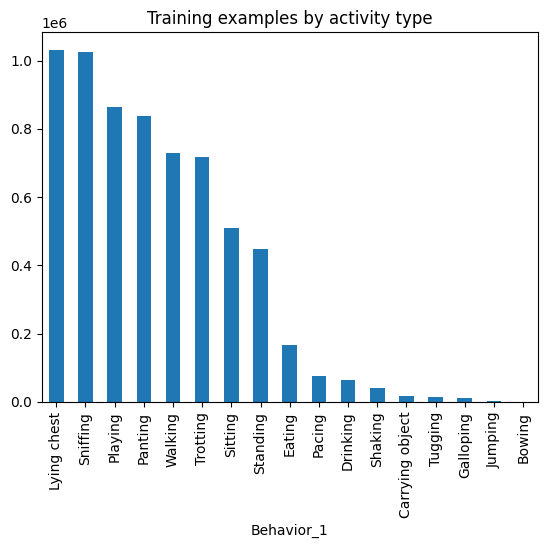

In [6]:
data['Behavior_1'].value_counts().plot(kind='bar', title='Training examples by activity type');


In [7]:
print(data['Behavior_1'].unique())
l=data['Behavior_1'].unique()

['Walking' 'Shaking' 'Sniffing' 'Eating' 'Sitting' 'Trotting' 'Pacing'
 'Lying chest' 'Playing' 'Standing' 'Panting' 'Drinking' 'Galloping'
 'Carrying object' 'Tugging' 'Jumping' 'Bowing']


In [8]:
# Creating a instance of label Encoder.
le = LabelEncoder()
#s=['Walking','Standing','Jumping','Tugging','Carrying object','Galloping','Drinking','Panting','Playing','Shaking','Lying chest','Pacing','Trotting','Sitting','Bowing'] 

# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(data['Behavior_1'])
print(label)
print(data['Behavior_1'])
# printing label
label
data.drop("Behavior_1", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'Purchased'
data["Behavior_1"] = label 


[16 16 16 ... 12 12 12]
9081         Walking
9082         Walking
9083         Walking
9084         Walking
9085         Walking
              ...   
10611063    Sniffing
10611064    Sniffing
10611065    Sniffing
10611066    Sniffing
10611067    Sniffing
Name: Behavior_1, Length: 6556827, dtype: object


In [9]:
N_TIME_STEPS = 50
N_FEATURES = 12
step = 20
segments = []
labels = []
for i in range(0, len(data) - N_TIME_STEPS, step):
    x1 = data['ABack_x'].values[i: i + N_TIME_STEPS]
    y1 = data['ABack_y'].values[i: i + N_TIME_STEPS]
    z1 = data['ABack_z'].values[i: i + N_TIME_STEPS]
    x2 = data['ANeck_x'].values[i: i + N_TIME_STEPS]
    y2 = data['ANeck_y'].values[i: i + N_TIME_STEPS]
    z2 = data['ANeck_z'].values[i: i + N_TIME_STEPS]
    x3 = data['GBack_x'].values[i: i + N_TIME_STEPS]
    y3 = data['GBack_y'].values[i: i + N_TIME_STEPS]
    z3 = data['GBack_z'].values[i: i + N_TIME_STEPS]
    x4 = data['GNeck_x'].values[i: i + N_TIME_STEPS]
    y4 = data['GNeck_y'].values[i: i + N_TIME_STEPS]
    z4 = data['GNeck_z'].values[i: i + N_TIME_STEPS]

    label = stats.mode(data['Behavior_1'][i: i + N_TIME_STEPS])[0][0]
    segments.append([x1, y1, z1,x2, y2, z2,x3, y3, z3,x4, y4, z4])
    labels.append(label)

C:\Users\karee\AppData\Local\Temp\ipykernel_24156\2465257851.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(data['Behavior_1'][i: i + N_TIME_STEPS])[0][0]


In [10]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [11]:

import numpy as np
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

# Reshape reshaped_segments to 2D array
reshaped_segments_2d = reshaped_segments.reshape(reshaped_segments.shape[0], -1)

# Shuffle the data and labels consistently
reshaped_segments_2d, labels = shuffle(reshaped_segments_2d, labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments_2d, labels, test_size=0.3, random_state=2)

# Reshape X_train to have 2 dimensions
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2d, y_train)

# Reshape X_train_resampled to 3D with n_time_steps = 70 and n_features = 12
X_train_resampled_3d = X_train_resampled.reshape(-1, N_TIME_STEPS, N_FEATURES)

print(X_train_resampled_3d.shape)


(615128, 50, 12)


In [12]:
x=np.shape(X_train)

print(x)

(229487, 600)


In [13]:
reshaped_segments.shape

(327839, 50, 12)

In [14]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(N_TIME_STEPS, N_FEATURES), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=17, activation='softmax'))

In [15]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           72192     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4

In [17]:
log_dir = "logs/fit/LSTMFINALFINAL" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
history = model.fit(X_train_resampled_3d, y_train_resampled, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split,callbacks=[tensorboard_callback])
#model.save("LSTMmodel")

Epoch 1/25
7690/7690 [==============================] - 627s 81ms/step - loss: 0.8302 - accuracy: 0.7057 - val_loss: 2.1997 - val_accuracy: 0.5334
Epoch 2/25
7690/7690 [==============================] - 615s 80ms/step - loss: 0.5015 - accuracy: 0.8299 - val_loss: 2.0167 - val_accuracy: 0.5728
Epoch 3/25
7690/7690 [==============================] - 730s 95ms/step - loss: 0.4170 - accuracy: 0.8599 - val_loss: 1.9074 - val_accuracy: 0.5934
Epoch 4/25
7690/7690 [==============================] - 674s 88ms/step - loss: 0.3709 - accuracy: 0.8762 - val_loss: 1.9693 - val_accuracy: 0.5899
Epoch 5/25
7690/7690 [==============================] - 673s 88ms/step - loss: 0.3413 - accuracy: 0.8857 - val_loss: 1.9039 - val_accuracy: 0.5885
Epoch 6/25
7690/7690 [==============================] - 508s 66ms/step - loss: 0.3197 - accuracy: 0.8937 - val_loss: 1.8597 - val_accuracy: 0.6032
Epoch 7/25
7690/7690 [==============================] - 681s 89ms/step - loss: 0.3028 - accuracy: 0.8992 - val_loss: 1

In [19]:
%tensorboard --logdir=data/ --host localhost --port 8888
model.save("TRIALmodel")

UsageError: Line magic function `%tensorboard` not found.


In [20]:
from tensorflow.keras.models import load_model
model.save("TRIALmodel")
rmodel=load_model("TRIALmodel")
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 50, 12))

test_results =rmodel.evaluate(X_test_reshaped, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
#actual=


INFO:tensorflow:Assets written to: TRIALmodel\assets


INFO:tensorflow:Assets written to: TRIALmodel\assets


Test results - Loss: 0.4181188941001892 - Accuracy: 87.39425539970398%


In [21]:
model.save("TRIALmodel")

INFO:tensorflow:Assets written to: TRIALmodel\assets


INFO:tensorflow:Assets written to: TRIALmodel\assets


3074/3074 [==============================] - 24s 8ms/step
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(17, 17)


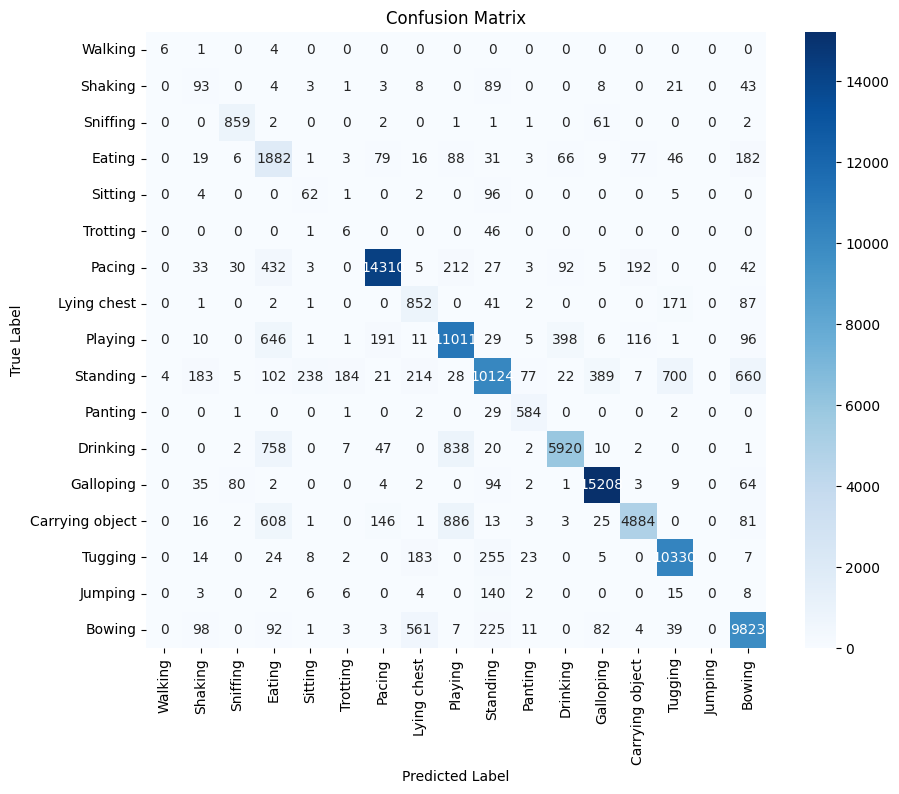

In [22]:
#pl=[]
#s={'Bowing': 0,'Carrying object': 1,'Drinking': 2,'Eating': 3,'Galloping': 4,'Jumping': 5,'Lying chest': 6,'Pacing': 7,'Panting':8,'Playing':9,'Shaking':10,'Sitting':11,'Sniffing':12,'Standing':13,'Trotting':14,'Tugging':15,'Walking':16}

rmodel=load_model("TRIALmodel")
y_pred = np.argmax(rmodel.predict(X_test_reshaped), axis=1)
y_true = np.argmax(y_test, axis=1)
print(y_test)
cm = confusion_matrix(y_true, y_pred)
print(cm.shape)
#[s[i] for i in y_true]
#unique_classes=['Walking','Standing','Jumping','Tugging','Carrying object','Galloping','Drinking','Panting','Playing','Shaking','Lying chest','Pacing','Trotting','Sitting','Bowing']
# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, columns=l, index=l)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
#import csv

#open the file in the write mode
#f = open('path/to/csv_file', 'w')

#create the csv writer
#writer = csv.writer(f)

#write a row to the csv file
#writer.writerow(row)

#close the file
#f.close()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred,average='macro')*100

# Calculate recall
recall = recall_score(y_true, y_pred,average='macro')*100

# Calculate F1 score
f1 = f1_score(y_true, y_pred,average='macro')*100

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)*100


print(precision)
print(recall)
print(f1)
print(accuracy)

63.86701209663084
68.5308272741031
65.09706100336437
87.39425736131446


C:\Users\karee\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
